In [1]:
import os
from typing import Tuple

img_size = (32, 32)
batch_size = 128
num_classes = 3
base_dir = "/home/miki/Documents/studia/2sem/image_processing/project/data"

def get_img_paths(img_size) -> Tuple[list, list]:
    train_x_dir =  os.path.join(base_dir, "train", "patches", f"{img_size[0]}_{img_size[1]}", "image")
    train_y_dir =  os.path.join(base_dir, "train", "patches", f"{img_size[0]}_{img_size[1]}", "label")

    x_img_paths = sorted(
        [
            os.path.join(train_x_dir, fname)
            for fname in os.listdir(train_x_dir)
            if fname.endswith(".png")
        ]
    )
    y_img_paths = sorted(
        [
            os.path.join(train_y_dir, fname)
            for fname in os.listdir(train_y_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )

    print("Number of samples:", len(x_img_paths))

    for input_path, target_path in zip(x_img_paths[:10], y_img_paths[:10]):
        print(input_path, "|", target_path)
    
    return x_img_paths, y_img_paths

train_x_paths, train_y_paths = get_img_paths(img_size)


FileNotFoundError: [Errno 2] No such file or directory: '/home/miki/Documents/studia/2sem/image_processing/project/data/train/patches/32_32/image'

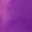

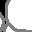

In [ ]:
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(load_img(train_x_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(train_y_paths[9]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class Biopsy(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, train_x_paths, train_y_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.train_x_paths = train_x_paths
        self.train_y_paths = train_y_paths

    def __len__(self):
        return len(self.train_y_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_train_x_paths = self.train_x_paths[i : i + self.batch_size]
        batch_train_y_paths = self.train_y_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_train_x_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_train_y_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 32)   0           ['batch_normalization[0][0]']

In [ ]:
import random

val_samples = round(len(train_x_paths)*0.2)
print(val_samples)
random.Random(1337).shuffle(train_x_paths)
random.Random(1337).shuffle(train_y_paths)
train_train_x_paths = train_x_paths[:-val_samples]
train_train_y_paths = train_y_paths[:-val_samples]
val_train_x_paths = train_x_paths[-val_samples:]
val_train_y_paths = train_y_paths[-val_samples:]

train_gen = Biopsy(
    batch_size, img_size, train_train_x_paths, train_train_y_paths
)
val_gen = Biopsy(batch_size, img_size, val_train_x_paths, val_train_y_paths)

3567


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", run_eagerly=True, metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", monitor="val_loss", save_best_only=True)
]

epochs = 100
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
111/111 [==============================] - 22s 137ms/step - loss: 0.9306 - accuracy: 0.6835 - val_loss: 1.0029 - val_accuracy: 0.5197
Epoch 2/10
111/111 [==============================] - 16s 142ms/step - loss: 0.6180 - accuracy: 0.7425 - val_loss: 0.9244 - val_accuracy: 0.6082
Epoch 3/10
111/111 [==============================] - 15s 135ms/step - loss: 0.5772 - accuracy: 0.7597 - val_loss: 0.8582 - val_accuracy: 0.6373
Epoch 4/10
111/111 [==============================] - 14s 127ms/step - loss: 0.5489 - accuracy: 0.7719 - val_loss: 0.7725 - val_accuracy: 0.6724
Epoch 5/10
111/111 [==============================] - 15s 132ms/step - loss: 0.5299 - accuracy: 0.7789 - val_loss: 0.5902 - val_accuracy: 0.7589
Epoch 6/10
111/111 [==============================] - 15s 138ms/step - loss: 0.5125 - accuracy: 0.7857 - val_loss: 0.5597 - val_accuracy: 0.7698
Epoch 7/10
111/111 [==============================] - 15s 137ms/step - loss: 0.4984 - accuracy: 0.7911 - val_loss: 0.5693 - val_ac

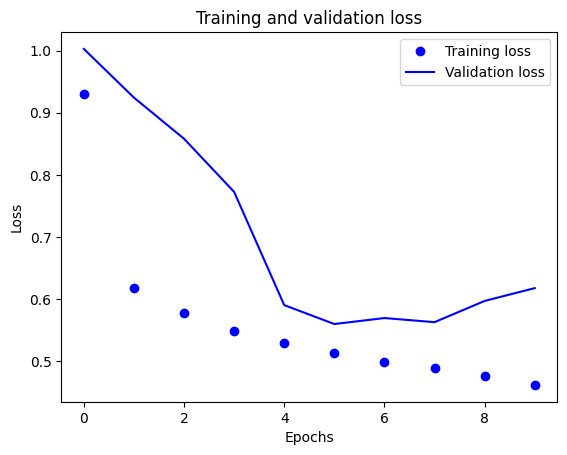

In [ ]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.plot(range(epochs), loss_values, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

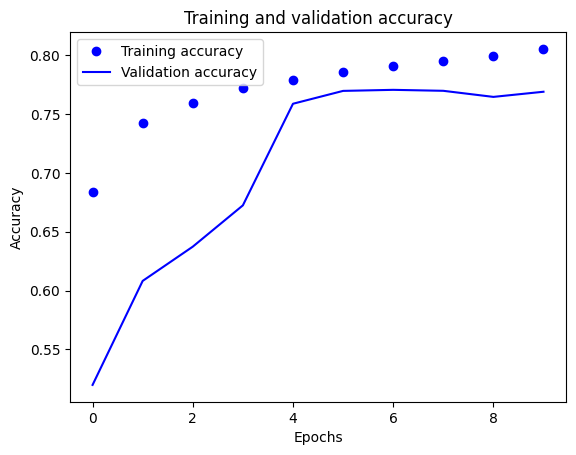

In [ ]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.plot(range(epochs), accuracy_values, 'bo', label='Training accuracy')
plt.plot(range(epochs), val_accuracy_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
test_x_dir =  os.path.join(base_dir, "test", "patches", f"{img_size[0]}_{img_size[1]}", "image")
test_y_dir =  os.path.join(base_dir, "test", "patches", f"{img_size[0]}_{img_size[1]}", "label")

test_x_paths = sorted(
    [
        os.path.join(test_x_dir, fname)
        for fname in os.listdir(test_x_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_y_paths = sorted(
    [
        os.path.join(test_y_dir, fname)
        for fname in os.listdir(test_y_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_gen = Biopsy(batch_size, img_size, test_x_paths, test_y_paths)
test_results = model.evaluate(test_gen)

print(f"Test loss: {test_results[0]:.4f}")
print(f"Test acc: {test_results[1]:.4f}")

19/19 [==============================] - 1s 61ms/step - loss: 1.0614 - accuracy: 0.6785
Test: 1.0614
Test: 0.6785


In [2]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/home/miki/repos/uz/breakhis/vcs/scripts/common/biopsy_segmentation.h5')

2023-12-27 22:35:02.802395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 22:35:11.886256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:12.029030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 22:35:12.029244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kerne

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the PNG image
image_path = '/home/miki/repos/uz/breakhis/vcs/data/400x/patches_with_random_stride/benign/SOB_B_TA-14-21978AB-400-014_fixed_1.png'
img = load_img(image_path, target_size=(256, 256))  # Adjust target size as needed
img_array = img_to_array(img)
predictions = model.predict(img_array.reshape(1, *img_array.shape))


2023-12-27 22:35:33.599195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


1/1 [==============================] - 9s 9s/step


In [5]:
predictions

array([[[[0.7973457 , 0.07323319, 0.12942107],
         [0.85982865, 0.07568322, 0.06448814],
         [0.8498379 , 0.07984017, 0.07032192],
         ...,
         [0.77327675, 0.08547244, 0.14125088],
         [0.79729193, 0.07247904, 0.13022904],
         [0.83046496, 0.06548391, 0.10405117]],

        [[0.89659345, 0.04988686, 0.05351971],
         [0.92390525, 0.04732141, 0.02877337],
         [0.9236876 , 0.04780198, 0.02851044],
         ...,
         [0.8773294 , 0.0363846 , 0.08628601],
         [0.8781289 , 0.03078136, 0.09108973],
         [0.77132094, 0.04486899, 0.18381004]],

        [[0.88821596, 0.04908623, 0.06269777],
         [0.91248214, 0.05290849, 0.03460938],
         [0.9187031 , 0.04934805, 0.03194888],
         ...,
         [0.8647831 , 0.03919397, 0.09602293],
         [0.8739594 , 0.03242752, 0.09361306],
         [0.7734262 , 0.0431856 , 0.18338819]],

        ...,

        [[0.9021787 , 0.04392741, 0.05389399],
         [0.8861181 , 0.04161798, 0.0722639 ]

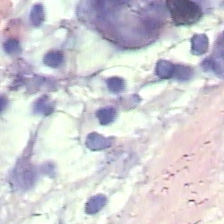

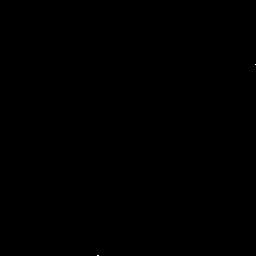

In [6]:
import numpy as np
from IPython.display import Image, display
from PIL import ImageOps

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(predictions[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    display(img)
    
i = 0

# Display input image
display(Image(filename=image_path))

# Display ground-truth target mask
# display( ImageOps.autocontrast(load_img(test_y_paths[i])))

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.